In [160]:
import pandas as pd
import json
import glob
from collections import Counter
from typing import List, Dict
from collections import OrderedDict
import warnings
import plot_likert
import numpy as np
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)
statistic_dir = "../data/statistics/"

In [161]:
def df_to_latex(df: pd.DataFrame) -> None:
    print(df.to_latex(index=False))

def get_module(name, data):
    module = next(filter(lambda x: name == x["name"], data))
    return module

with open("../data/statistic_files_per_year.json", "r", encoding="utf-8") as src:
    data = json.load(src)
    #print(len(data))
    #data = data[8:]

    #for item in data:
    #    print(item["year"])

In [162]:
def create_plot(name, year, value_a, value_b) -> str:

    font = {'family' : 'DeJavu Serif',
            'weight' : 'bold',
            'size'   : 22}
    plt.rc('font', **font)

    values = [(value_a, value_b)] #, (100, 0), (0,100), (26.5, 73.5), (8.3, 91.7), (22, 78), (16.3, 83.7)]

    values = [(round(x[0]*100), round(x[1]*100)) for x in values]
    columns = [f"({value_a}, {value_b})"] # , "(100, 0)", "(0,100)", "(26.5, 73.5)","(8.3, 91.7)", "(22, 78)","(16.3, 83.7)"]

    data = {} 

    for i, col_name in enumerate(columns):
        data[col_name] = ["Strongly disagree"] * values[i][0] +  ["Strongly agree"] * values[i][1]

    data = pd.DataFrame(data)



    rng = np.random.default_rng(seed=42)
    #data = pd.DataFrame(rng.choice(plot_likert.scales.agree, (10,2)), columns=['Q1','Q2'])
    ax = plot_likert.plot_likert(data, plot_likert.scales.agree, plot_percentage=False, label= "(100, 0) to (0, 100)",
                            bar_labels=True, colors=['#ffffff00', '#d8a539', '#efe0c1', 'lightgray', '#bde1dd', '#5ab4ac'], figsize=(8,4), xticks = [-100, -50, 0,50,100], bar_labels_color="black")

    # Remove the x and y axis 
    plt.axis('off')
    ax.text(-2000, -0.1, f'{round(value_a * 100), 1}',)
    ax.text(11000, -0.1, f'{round(value_a * 100), 1}',)
    plt.legend('',frameon=False)

    file_path = f'../data/{name}/{name}_{year}.png'

    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)

    return file_path

In [163]:
def count_ml_method_params(library_name: str, library_dir: str, files: str, year: int) -> pd.DataFrame:

    with open(library_dir, "r", encoding="utf-8") as library_file:
        library_data = json.load(library_file)
        class_names = [module["name"] for module in library_data]

    total_params_set = 0
    total_params_available = 0
    default_params = 0
    customized_params = 0

    for project in files:
        with open(statistic_dir + project, "r", encoding="utf-8") as project_file:
            project_data = json.load(project_file)

            for file in project_data.keys():
                file_data = project_data[file]
                for library in file_data.keys():
                    if library == library_name:
                        module_data = file_data[library]
                        for key, data in module_data.items():
                            if key[0].isupper():
                                class_name_parts = key.split("_")
                                if len(class_name_parts) > 2:
                                    class_name = "_".join(class_name_parts[:-1])
                                else:
                                    class_name = class_name_parts[0]
                                
                                if class_name not in class_names:
                                    continue

                                library_module_data = get_module(class_name, library_data)
                                library_module_params = library_module_data["params"]
                                total_params_available += len(library_module_params)

                                for name, value in data.items():
                                    if name in ("variable", "params"):
                                        continue
                                    else:
                                        total_params_set += 1
                                        if name in library_module_params.keys():

                                            if str(library_module_params[name]).replace("'", "") == value["value"]:
                                                default_params += 1
                                            else:
                                                customized_params += 1
                                        else:
                                            customized_params += 1


    assert total_params_set == default_params + customized_params


    df = pd.DataFrame()
    df["Year"] = [year]
    df["Paper Count"] = [len(files)]
    df["Available"] = [total_params_available]
    df["Set"] = [total_params_set]

    if total_params_set > 0:
        default_per = round(default_params/total_params_set, 2)
        custom_per = round(customized_params/total_params_set, 2)
        values = [(default_per, custom_per)]
        print("Values: ", values, year)

    return df


# Count params of ML methods across the code repositories for which the respective paper reported hyperparameter tuning
with open("../data/repos_hyperparameter_tuning.json", "r", encoding="utf-8") as src:
    repos_files = json.load(src)

#df_sklearn = count_ml_method_params("sklearn", "../data/library_data/sklearn_estimators.json" , repos_files)#
#df_tf = count_ml_method_params("tensorflow", "../data/library_data/tensorflow_optimizer.json" , repos_files)
#df_pytorch = count_ml_method_params("torch", "../data/library_data/torch_optimizer.json" , repos_files)
#df_all = pd.concat([df_sklearn, df_tf, df_pytorch])

#df_to_latex(df_all)

In [164]:
def get_hp_tuning_stats_per_year(data: List, library_name: str, library_dir: str):
    dfs = []

    for item in data:
        files = item["hp_yes"]

        if not files:
            df = pd.DataFrame()
            df["Year"] = [item["year"]]
            df["Paper Count"] = [len(files)]
            df["Available"] = [0]
            df["Set"] = [0]
            df["Default"] = [0]
            df["Custom"] = [0]
            dfs.append(df)
            continue

        df = count_ml_method_params(library_name=library_name, library_dir=library_dir, files=files, year=item["year"])
        dfs.append(df)
    
    df_all = pd.concat(dfs)
    return df_all

df_sklearn = get_hp_tuning_stats_per_year(data, "sklearn", "../data/library_data/sklearn_estimators.json")
#df_tf = get_hp_tuning_stats_per_year(data, "tensorflow", "../data/library_data/tensorflow_optimizer.json")
#df_torch = get_hp_tuning_stats_per_year(data, "torch", "../data/library_data/torch_optimizer.json")
            
#df_to_latex(df_sklearn)
#df_to_latex(df_tf)
#df_to_latex(df_torch)


Values:  [(0.0, 1.0)] 2011
Values:  [(1.0, 0.0)] 2016
Values:  [(0.0, 1.0)] 2017
Values:  [(0.26, 0.74)] 2018
Values:  [(0.08, 0.92)] 2019
Values:  [(0.22, 0.78)] 2020
Values:  [(0.16, 0.84)] 2021


C:\Users\Basti\AppData\Local\Temp\ipykernel_17736\141139920.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, figsize=(22, 2))


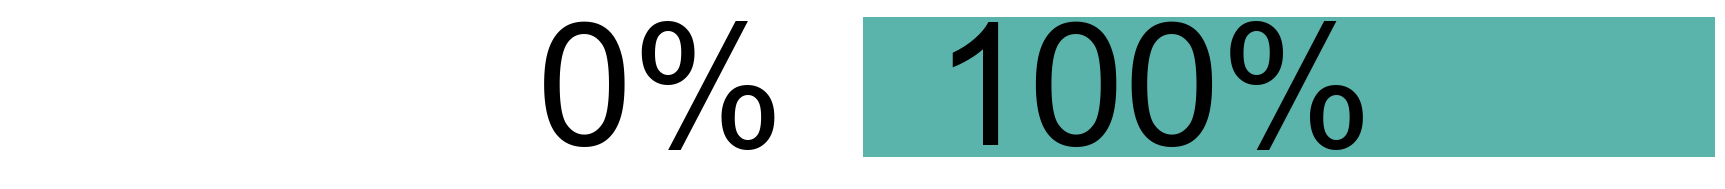

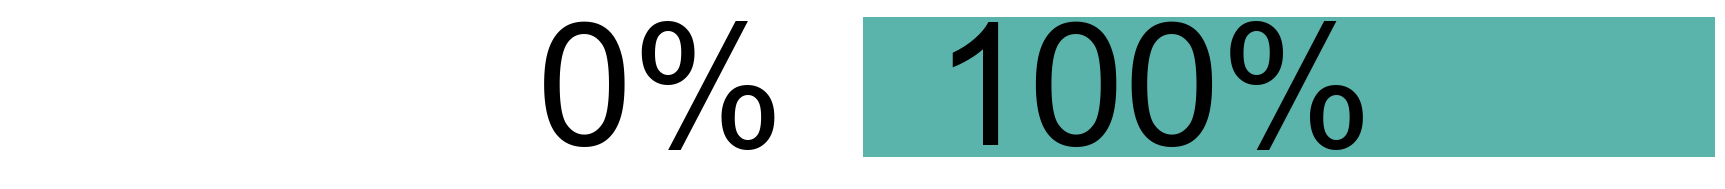

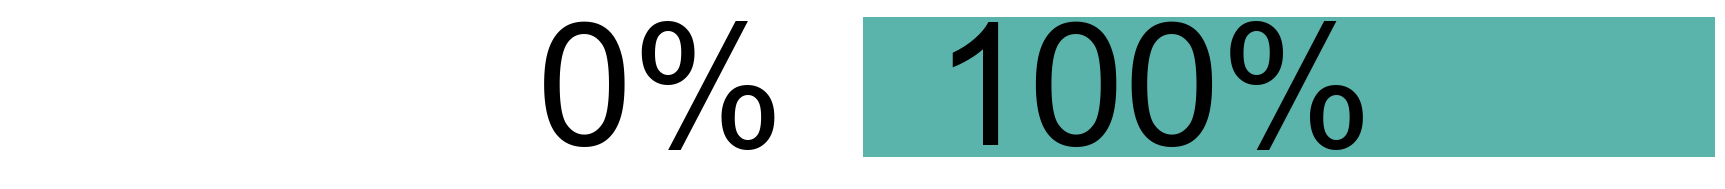

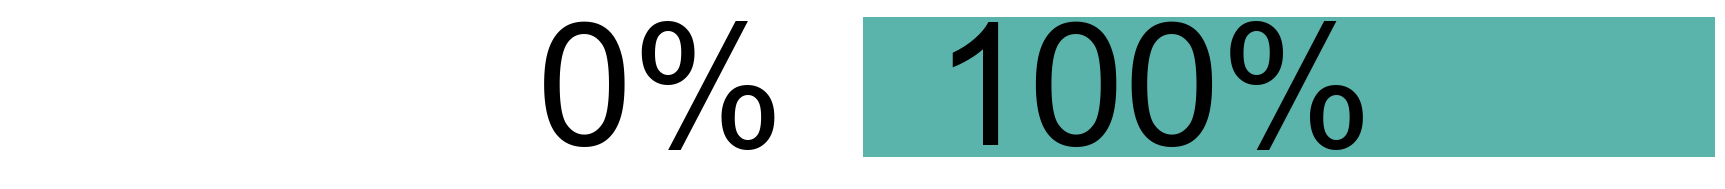

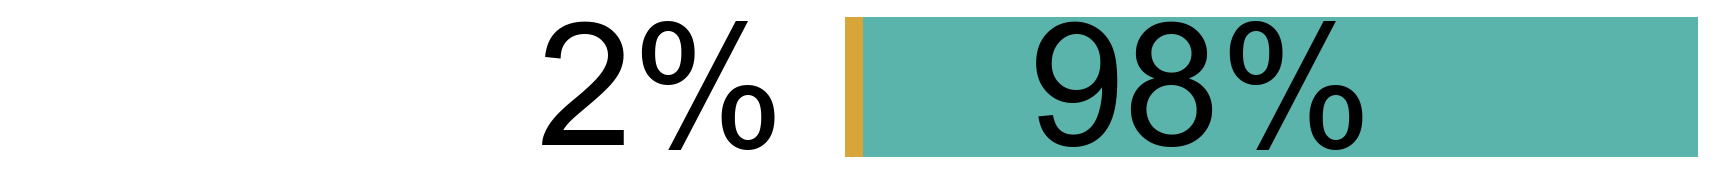

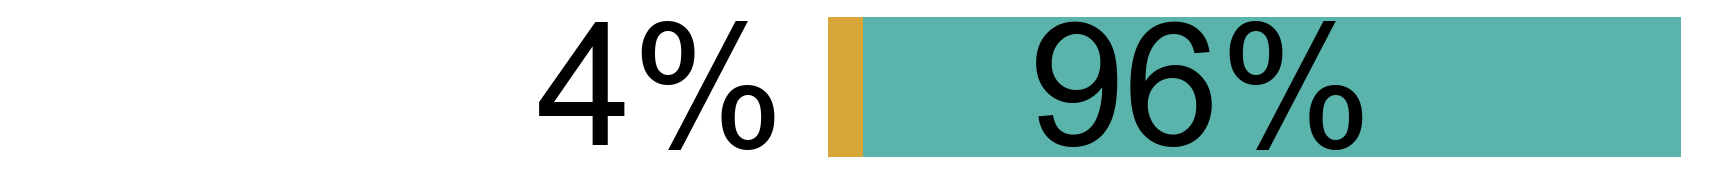

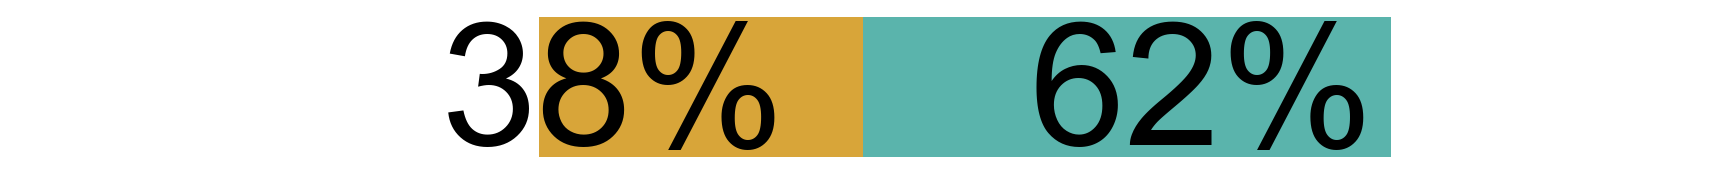

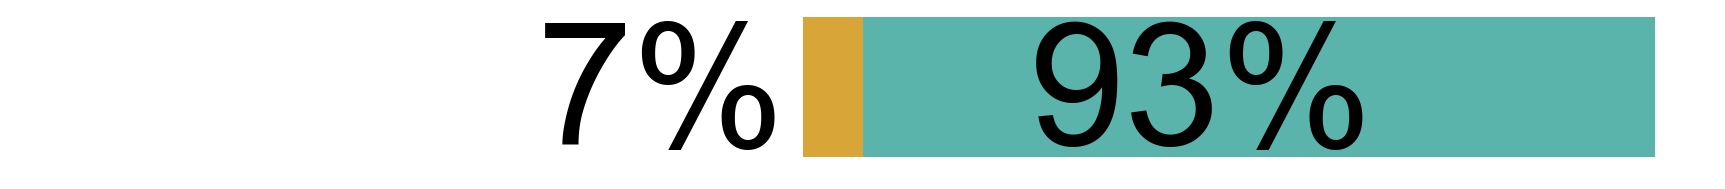

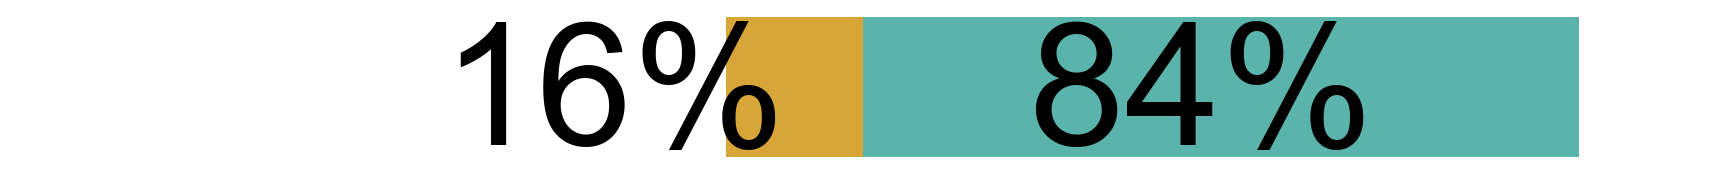

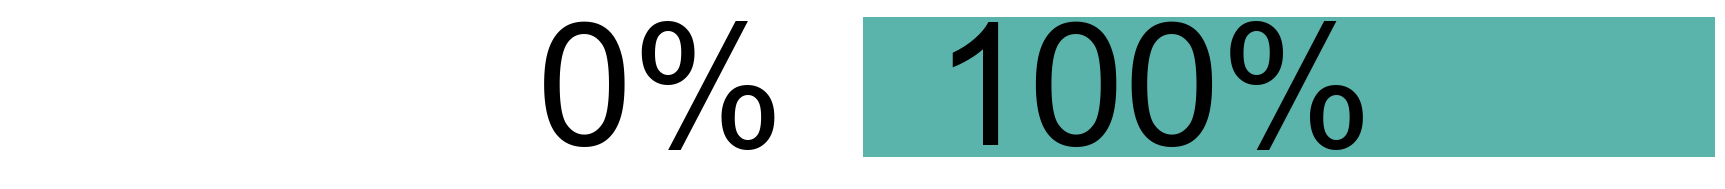

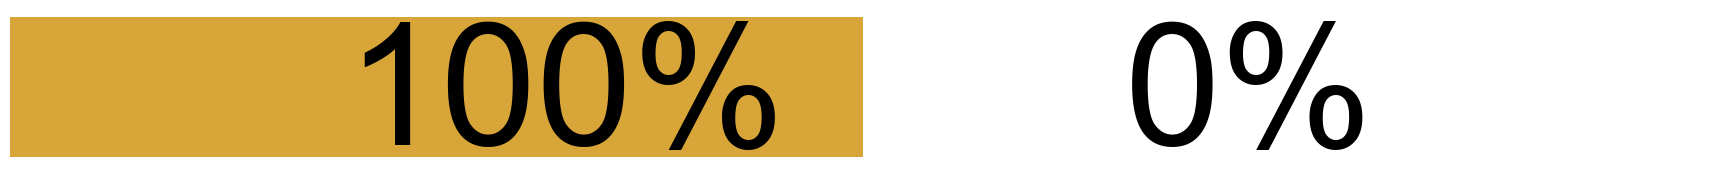

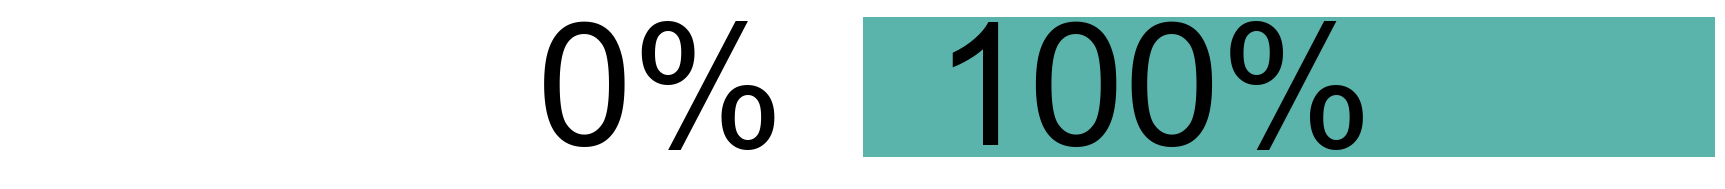

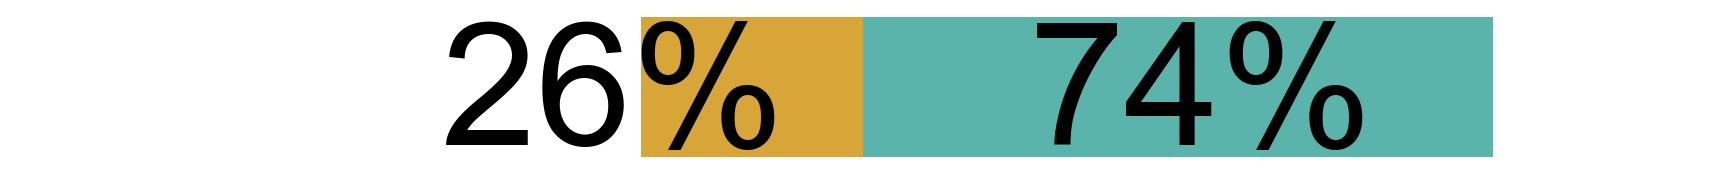

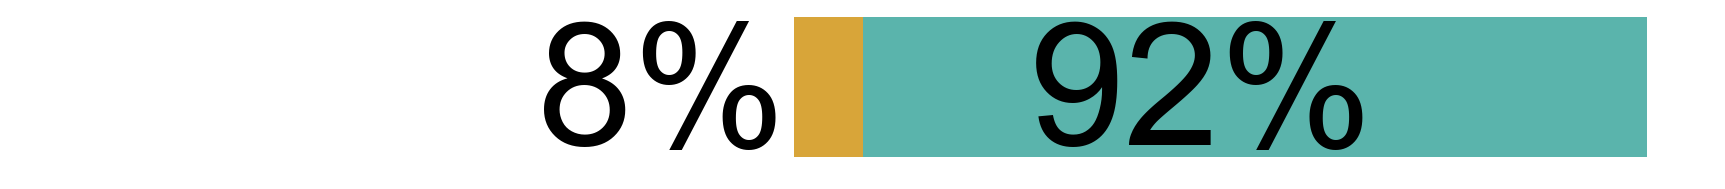

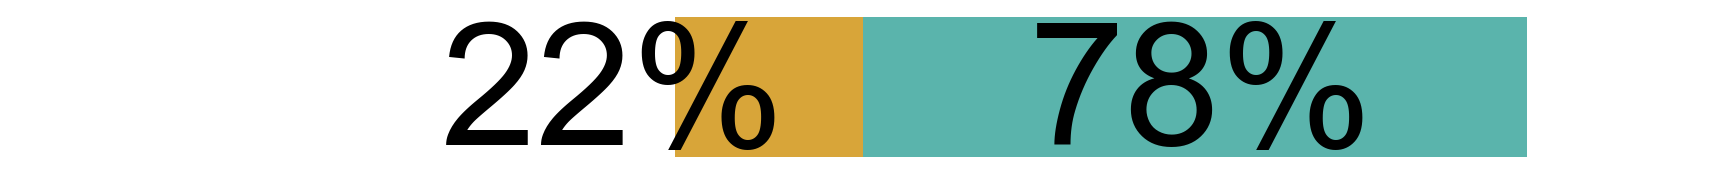

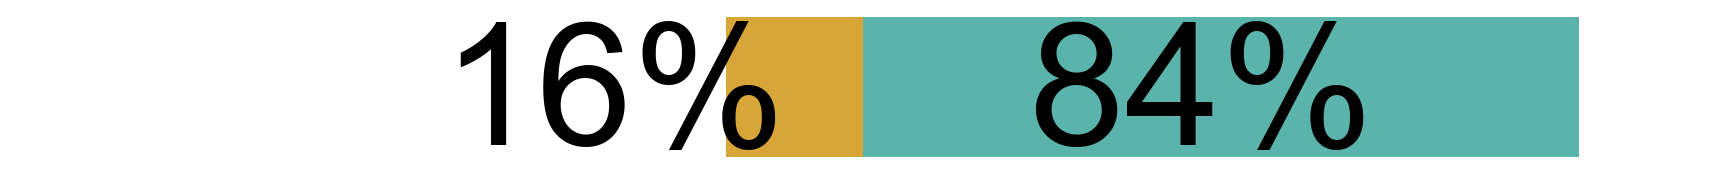

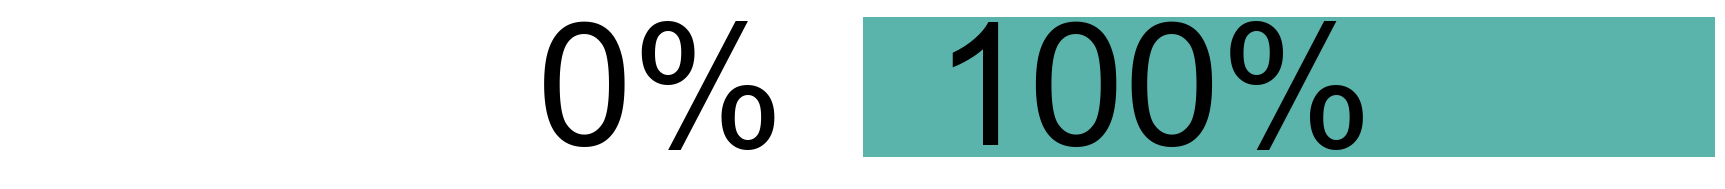

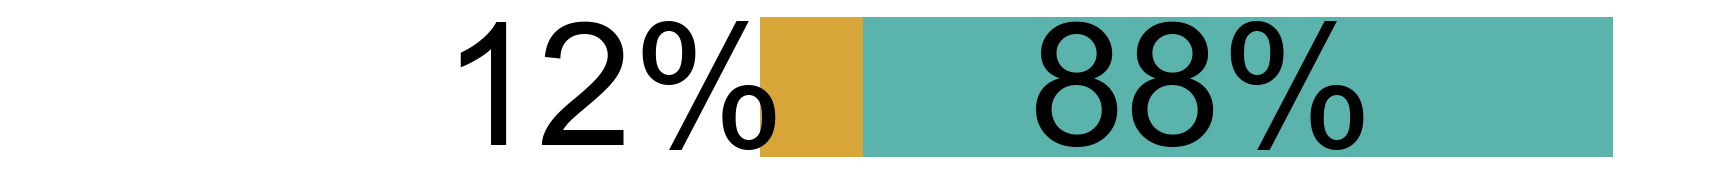

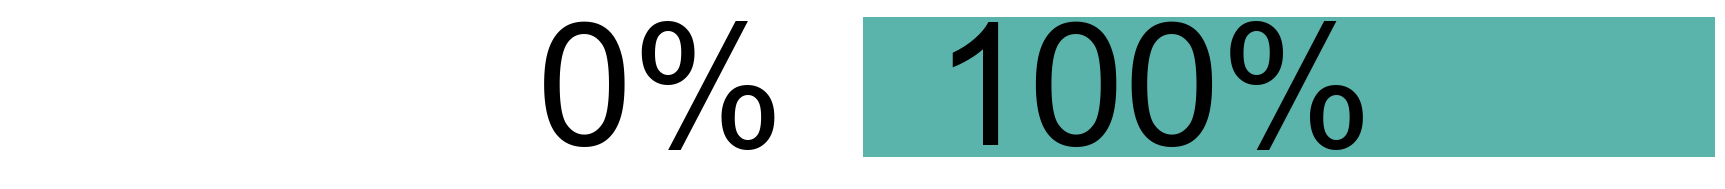

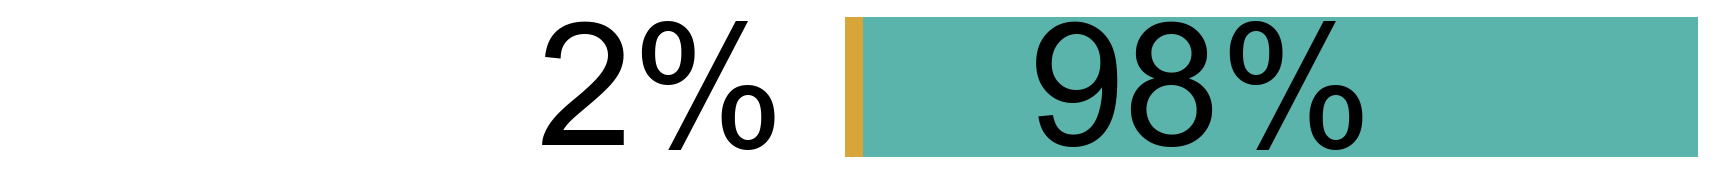

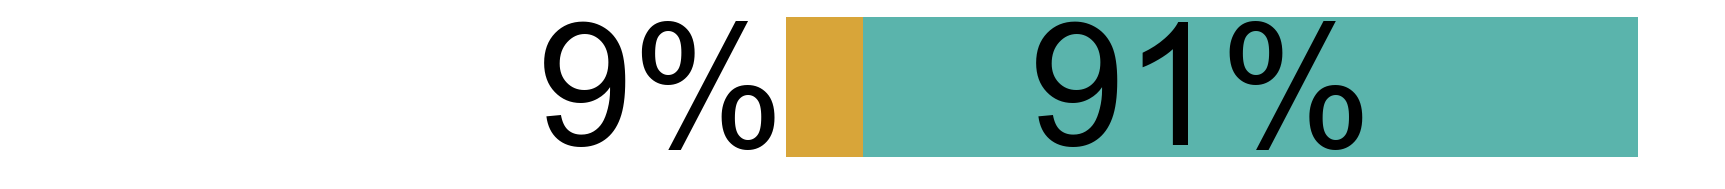

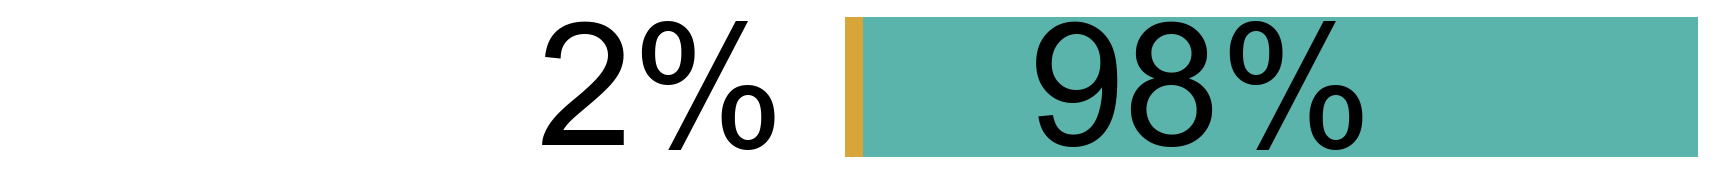

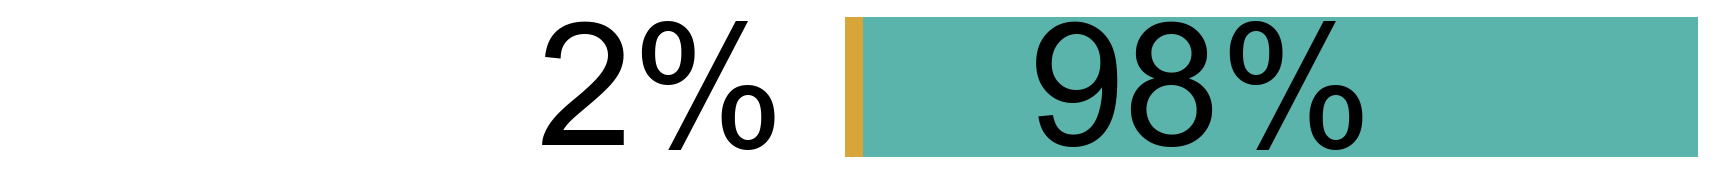

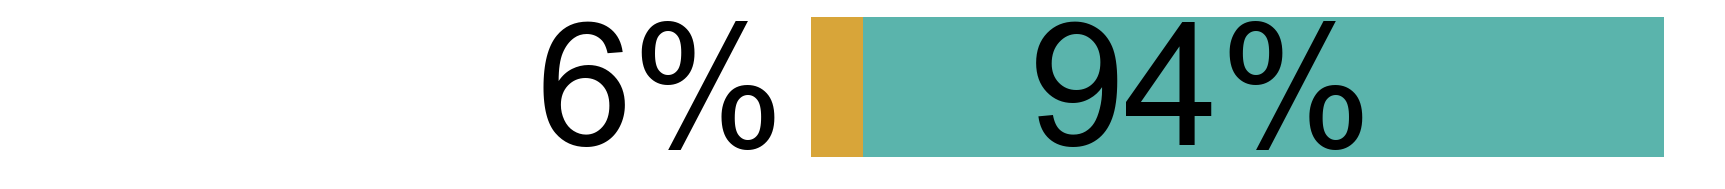

In [259]:
import matplotlib.pyplot as plt
from PIL import Image

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)
sklearn_values = [(0, 100),(100, 0),(0, 100),(26, 74), (8, 92), (22, 78), (16, 84)]
sklearn_year = ["2011", "2016", "2017", "2018", "2019","2020", "2021"]
tf_values = [(0, 100),(0, 100),(0, 100), (0, 100), (2, 98), (4, 96), (38, 62), (7, 93), (16, 84)]
tf_year = ["2013", "2014", "2015", "2016", "2017", "2018", "2019","2020", "2021"]
torch_values = [(0, 100),(12, 88),(0, 100), (2, 98), (9, 91), (2, 98), (2, 98), (6, 94)]
torch_year = ["2014", "2015", "2016", "2017", "2018", "2019","2020", "2021"]

def plot(name, values, year):
    fig, ax = plt.subplots(1, figsize=(22, 2))

    # Create a horizontal bar plot with the values
    plt.barh(1, values[0], color = '#d8a539', height = 0.1, left=-values[0])
    plt.barh(1, values[1], color = '#5ab4ac', height = 0.1, left=0)

    left_value = values[0]
    right_value = values[1]        

    #if len(str(left_value)) == 1:
    #    formatted_left = "{:.0f}%".format(left_value).rjust(10)
    #    if len(str(values[1])) == 2:
    #        formatted_right = "{:.0f}%".format(right_value).rjust(5)
    #    else:
    #        formatted_right = "{:.0f}%".format(right_value).rjust(1)
    #elif len(str(left_value)) == 2:
    #    formatted_left = "{:.0f}%".format(left_value).rjust(7)
    #    formatted_right = "{:.0f}%".format(right_value).rjust(1)
    #elif len(str(left_value)) == 3:
    #    formatted_left = "{:.0f}%".format(left_value)
    #    if len(str(right_value)) == 2:
    #        formatted_right = "{:.0f}%".format(right_value).ljust(1)
       # else:
       #     formatted_right = "{:.0f}%".format(right_value).ljust(1)
    formatted_right = "{:.0f}%".format(right_value)
    formatted_left = "{:.0f}%".format(left_value)
    

    ax.text(-9, 0.99, formatted_left, fontsize=124, ha='right', va='center')
    ax.text(60, 0.99, formatted_right, fontsize=124, ha='right', va='center')

 
    
    # Add y axis label
    #plt.yticks([1], ["",""])
    ax.set_yticks([])
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([-100, -50, 0, 50, 100])
    ax.set_xticklabels(['100%', '50%', '0%', '50%', '100%'])
    # Set x axis limit
    plt.xlim(-100,100)

    #plt.show()
    plt.axis('off')
    #plt.legend('',frameon=False)

    file_path = f'../data/{name}/{name}_{year}.png'

    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)#

for x, y in zip(tf_values, tf_year):
    plot("tf", x,y)

for x, y in zip(sklearn_values, sklearn_year):
    plot("sklearn", x,y)

for x, y in zip(torch_values, torch_year):
    plot("torch", x,y)